In [1]:
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader,Subset
from torchvision.transforms import transforms

#from objects.dataset import DFGANDataset


def create_loader(imsize: int, batch_size: int, data_dir: str, split: str) -> DataLoader:
    assert split in ["train", "test"], "Wrong split type, expected train or test"
    image_transform = transforms.Compose([
        transforms.Resize(int(imsize * 76 / 64)),
        transforms.RandomCrop(imsize),
        transforms.RandomHorizontalFlip()
    ])

    dataset = DFGANDataset(data_dir, split, image_transform)
    
    n_words = dataset.n_words
    
    subset_size=6000
    shuffled_indices = torch.randperm(len(dataset))[:6000].tolist()
    dataset = Subset(dataset, shuffled_indices)
    

    print(len(dataset))

    return DataLoader(dataset, batch_size=batch_size, drop_last=True,shuffle=True),n_words


def fix_seed(seed: int = 123321):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    print(f"Seed {seed} fixed")




In [2]:
import os
import pickle
from typing import Dict, List, Optional, Tuple

import numpy as np
import numpy.random as random
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from torchvision.transforms import Compose


class DFGANDataset(Dataset):
    def __init__(self, data_dir: str, split: str = "train", transform: Optional[Compose] = None):
        self.split = split
        self.data_dir = data_dir

        self.split_dir = os.path.join(data_dir, split)
        self.captions_path = os.path.join(self.data_dir, "captions.pickle")
        self.filenames_path = os.path.join(self.split_dir, "filenames.pickle")

        self.transform = transform

        self.embeddings_num = 10

        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.images_dir = os.path.join(self.data_dir, "CUB_200_2011/CUB_200_2011/images")
        self.bbox_path = os.path.join(self.data_dir, "CUB_200_2011/CUB_200_2011/bounding_boxes.txt")
        self.images_path = os.path.join(self.data_dir, "CUB_200_2011/CUB_200_2011/images.txt")

        self.bbox = self._load_bbox()

        self.file_names, self.captions, self.code2word, self.word2code = self._load_text_data()

        self.n_words = len(self.code2word)
        self.num_examples = len(self.file_names)

        self._print_info()

    def _print_info(self):
        print(f"Total filenames: {len(self.bbox)}")
        print(f"Load captions from: {self.captions_path}")
        print(f"Load file names from: {self.filenames_path} ({self.num_examples})")
        print(f"Dictionary size: {self.n_words}")
        print(f"Embeddings number: {self.embeddings_num}")

    def _load_bbox(self) -> Dict[str, List[int]]:
        df_bbox = pd.read_csv(self.bbox_path, delim_whitespace=True, header=None).astype(int)

        df_image_names = pd.read_csv(self.images_path, delim_whitespace=True, header=None)
        image_names = df_image_names[1].tolist()

        filename_bbox = dict()
        for i, file_name in enumerate(image_names):
            bbox = df_bbox.iloc[i][1:].tolist()
            filename_bbox[file_name[:-4]] = bbox

        return filename_bbox

    def _load_text_data(self) -> Tuple[List[str], List[List[int]],
                                       Dict[int, str], Dict[str, int]]:
        with open(self.captions_path, 'rb') as file:
            train_captions, test_captions, code2word, word2code = pickle.load(file)

        filenames = self._load_filenames()

        if self.split == 'train':
            return filenames, train_captions, code2word, word2code

        return filenames, test_captions, code2word, word2code

    def _load_filenames(self) -> List[str]:
        if os.path.isfile(self.filenames_path):
            with open(self.filenames_path, 'rb') as file:
                return pickle.load(file)

        raise ValueError(f"File {self.filenames_path} does not exist")

    def _get_caption(self, caption_idx: int) -> Tuple[np.ndarray, int]:
        caption = np.array(self.captions[caption_idx])
        pad_caption = np.zeros((18, 1), dtype='int64')

        if len(caption) <= 18:
            pad_caption[:len(caption), 0] = caption
            return pad_caption, len(caption)

        indices = list(np.arange(len(caption)))
        np.random.shuffle(indices)
        pad_caption[:, 0] = caption[np.sort(indices[:18])]

        return pad_caption, 18

    def _get_image(self, image_path: str, bbox: List[int]) -> Tensor:

        image = Image.open(image_path).convert('RGB')
        width, height = image.size

        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)

        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)

        image = image.crop((x1, y1, x2, y2))
        image = self.normalize(self.transform(image))

        return image

    def _get_random_caption(self, idx: int) -> Tuple[np.ndarray, int]:
        caption_shift = random.randint(0, self.embeddings_num-1)
        caption_idx = idx * self.embeddings_num + caption_shift

        if caption_idx >= len(self.captions):
            caption_idx = len(self.captions) - 1 
            
        return self._get_caption(caption_idx)

    def __getitem__(self, idx: int) -> Tuple[Tensor, np.ndarray, int, str]:
        file_name = self.file_names[idx]
        image = self._get_image(f"{self.images_dir}/{file_name}.jpg", self.bbox[file_name])

        encoded_caption, caption_len = self._get_random_caption(idx)

        return image, encoded_caption, caption_len, file_name

    def __len__(self) -> int:
        return self.num_examples

In [3]:
from typing import List, Tuple

import torch
from torch import Tensor


def prepare_data(batch: Tuple[Tensor, Tensor, Tensor, Tuple[str]],
                 device: torch.device) -> Tuple[Tensor, Tensor, Tensor, List[str]]:
    images, captions, captions_len, file_names = batch

    sorted_cap_lens, sorted_cap_indices = torch.sort(captions_len, 0, True)
    sorted_cap_lens = sorted_cap_lens.to(device)

    sorted_images = images[sorted_cap_indices].to(device)
    sorted_captions = captions[sorted_cap_indices].squeeze().to(device)
    sorted_file_names = [file_names[i] for i in sorted_cap_indices.numpy()]

    return sorted_images, sorted_captions, sorted_cap_lens, sorted_file_names


In [4]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class RNNEncoder(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5,
                 nhidden=128, nlayers=1, bidirectional=True):
        super().__init__()
        self.n_steps = 18
        self.ntoken = ntoken  # size of the dictionary
        self.ninput = ninput  # size of each embedding vector
        self.drop_prob = drop_prob  # probability of an element to be zeroed
        self.nlayers = nlayers  # Number of recurrent layers
        self.bidirectional = bidirectional
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        # number of features in the hidden state
        self.nhidden = nhidden // self.num_directions

        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)

        # dropout: If non-zero, introduces a dropout layer on
        # the outputs of each RNN layer except the last layer
        self.rnn = nn.LSTM(self.ninput, self.nhidden,
                           self.nlayers, batch_first=True,
                           dropout=self.drop_prob,
                           bidirectional=self.bidirectional)


    def forward(self, captions, cap_lens):
        # input: torch.LongTensor of size batch x n_steps
        # --> emb: batch x n_steps x ninput
        emb = self.drop(self.encoder(captions))
        #
        # Returns: a PackedSequence object
        cap_lens = cap_lens.data.tolist()
        emb = pack_padded_sequence(emb, cap_lens, batch_first=True)
        # #hidden and memory (num_layers * num_directions, batch, hidden_size):
        # tensor containing the initial hidden state for each element in batch.
        # #output (batch, seq_len, hidden_size * num_directions)
        # #or a PackedSequence object:
        # tensor containing output features (h_t) from the last layer of RNN
        output, hidden = self.rnn(emb)
        # PackedSequence object
        # --> (batch, seq_len, hidden_size * num_directions)
        output = pad_packed_sequence(output, batch_first=True)[0]
        words_emb = output.transpose(1, 2)
        #print('word',words_emb.shape)
        # output = self.drop(output)
        # --> batch x hidden_size*num_directions x seq_len
        # --> batch x num_directions*hidden_size
        sent_emb = hidden[0].transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)
        return sent_emb, words_emb

    @staticmethod
    def load(weights_path: str, ntoken: int) -> 'RNNEncoder':
        text_encoder = RNNEncoder(ntoken, nhidden=256)
        state_dict = torch.load(weights_path, map_location=lambda storage, loc: storage)
        text_encoder.load_state_dict(state_dict)
        return text_encoder



In [5]:
# !pip install torch torchvision clip-by-openai tqdm
!pip install open-clip-torch
!pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import open_clip
from torchvision import transforms
from tqdm import tqdm
import clip
import numpy as np
from torch.utils.data import DataLoader

# Step 2: Implement CLIP Encoder
class CLIPTextEncoder(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5, nhidden=128, bidirectional=True):
        super().__init__()
        self.n_steps = 18  # same as RNNEncoder
        self.ntoken = ntoken  # vocabulary size
        self.ninput = ninput  # embedding size (ignored for CLIP, but kept for compatibility)
        self.drop_prob = drop_prob  # dropout probability
        self.nlayers = 1  # transformers don't use nlayers in the same way as RNNs
        self.bidirectional = bidirectional  # not applicable for CLIP
        self.num_directions = 2 if bidirectional else 1
        self.nhidden = nhidden // self.num_directions  # match dimension of RNNEncoder

        # Load CLIP model
        self.clip_model, _ = clip.load("ViT-B/32", device="cpu")
        self.clip_model.eval()  # CLIP should be in eval mode

        # Adapter layer to match output dimension of RNNEncoder
        self.adapter = nn.Linear(512, self.nhidden * self.num_directions)

    def forward(self, captions, cap_lens):
        """
        Args:
            captions: Tuple or list of file paths or tokenized captions
            cap_lens: List of caption lengths
        Returns:
            sent_emb: Sentence embedding (batch_size, nhidden * num_directions)
            words_emb: Word embeddings (batch_size, nhidden * num_directions, seq_len)
        """
        batch_size = len(captions) if isinstance(captions, (list, tuple)) else captions.shape[0]
        
        # Process file paths directly - this is the key fix
        if isinstance(captions, tuple) or (isinstance(captions, list) and isinstance(captions[0], str)):
            # These are file paths, so we'll use them directly as text input
            caption_texts = []
            for path in captions:
                # Extract bird name from path (e.g., "Blue_Jay" from "073.Blue_Jay/Blue_Jay_0048_62433")
                bird_name = path.split('/')[0].split('.')[-1].replace('_', ' ').lower()
                caption_texts.append(f"a photo of a {bird_name}")
        else:
            # Handle token IDs if that's what we're getting
            caption_texts = []
            for i, length in enumerate(cap_lens):
                if isinstance(captions, torch.Tensor):
                    tokens = captions[i, :length].cpu().tolist()
                    text = " ".join([str(token) for token in tokens])
                else:
                    tokens = captions[i][:length]
                    text = " ".join([str(token) for token in tokens])
                caption_texts.append(text)
        
        tokens = clip.tokenize(caption_texts).to(next(self.clip_model.parameters()).device)



        
        # Get CLIP text embeddings
        with torch.no_grad():
            text_features = self.clip_model.encode_text(tokens)  # (batch, 512)
        
        # Project to match RNNEncoder output dimension
        sent_emb = self.adapter(text_features)  # (batch, nhidden * num_directions)
        
        # Simulate word embeddings by repeating sentence embeddings along sequence dimension
        words_emb = sent_emb.unsqueeze(2).repeat(1, 1, self.n_steps)  # (batch, hidden, seq_len)
        
        return sent_emb, words_emb



    @staticmethod
    def load(weights_path: str, ntoken: int) -> 'CLIPTextEncoder':
        model = CLIPTextEncoder(ntoken, nhidden=256)
        state_dict = torch.load(weights_path, map_location="cpu")
        model.load_state_dict(state_dict)
        return model

# Create a dataset class for training the CLIP adapter
class CLIPAdapterDataset(torch.utils.data.Dataset):
    def __init__(self, data_loader, rnn_encoder):
        self.samples = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Pre-compute RNN embeddings for training data
        rnn_encoder.eval()
        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Creating CLIP adapter dataset"):
                images, captions, captions_len, file_names = prepare_data(batch, self.device)
                
                # Get RNN embeddings as target
                sent_emb, words_emb = rnn_encoder(captions, captions_len)
                
                # Store the original file names and their RNN embeddings
                for i in range(len(file_names)):
                    self.samples.append((
                        file_names[i],  # Store filename as caption source
                        captions_len[i].item(),
                        sent_emb[i].cpu(),
                        words_emb[i].cpu()
                    ))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


# Train and Save the models
# def train_clip_adapter(model, dataset, epochs=300, lr=1e-4):
#     optimizer = torch.optim.Adam(model.adapter.parameters(), lr=lr)
#     criterion = nn.MSELoss()  # Match with precomputed RNN embeddings
#     model.train()
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)

#     for epoch in range(epochs):
#         epoch_loss = 0
#         batch_count = 0
        
#         for captions, cap_lens, target_sent_emb, target_words_emb in tqdm(dataset):
#             # Move tensors to device
#             if isinstance(target_sent_emb, torch.Tensor):
#                 target_sent_emb = target_sent_emb.to(device)
#             if isinstance(target_words_emb, torch.Tensor):
#                 target_words_emb = target_words_emb.to(device)
            
#             optimizer.zero_grad()
#             sent_emb, words_emb = model(captions, cap_lens)
            
#             # Ensure dimensions match
#             if sent_emb.shape != target_sent_emb.shape:
#                 print(f"Shape mismatch: sent_emb {sent_emb.shape}, target_sent_emb {target_sent_emb.shape}")
#                 continue
                
#             if words_emb.shape != target_words_emb.shape:
#                 print(f"Shape mismatch: words_emb {words_emb.shape}, target_words_emb {target_words_emb.shape}")
#                 continue
            
#             loss = criterion(sent_emb, target_sent_emb) + criterion(words_emb, target_words_emb)
#             loss.backward()
#             optimizer.step()
            
#             epoch_loss += loss.item()
#             batch_count += 1
            
#             # Print batch loss occasionally for debugging
#             if batch_count % 10 == 0:
#                 print(f"Batch {batch_count}, Loss: {loss.item():.4f}")

#         avg_epoch_loss = epoch_loss / max(batch_count, 1)  # Avoid division by zero
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Batches processed: {batch_count}")

#     torch.save(model.state_dict(), "/kaggle/working/clip_text_encoder.pth")
#     print("Model saved as /kaggle/working/clip_text_encoder.pth")


data_path = "/kaggle/input/projec/cv_seattention/cv_seattention/data"
train_loader, n_words = create_loader(256, 32, data_path, "train")

# Load the RNN encoder to get target embeddings
rnn_encoder = RNNEncoder.load("/kaggle/input/projec/cv_seattention/cv_seattention/text_encoder_weights/text_encoder200.pth", n_words)
rnn_encoder.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Create the adapter training dataset
clip_adapter_dataset = CLIPAdapterDataset(train_loader, rnn_encoder)
clip_adapter_loader = DataLoader(clip_adapter_dataset, batch_size=32, shuffle=True)

# Initialize CLIP Encoder
clip_encoder = CLIPTextEncoder(ntoken=n_words, nhidden=256)

# Train adapter
# train_clip_adapter(clip_encoder, clip_adapter_loader)


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k_c9637w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k_c9637w
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


/tmp/ipykernel_136/3649513097.py:54: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bbox = pd.read_csv(self.bbox_path, delim_whitespace=True, header=None).astype(int)
/tmp/ipykernel_136/3649513097.py:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_image_names = pd.read_csv(self.images_path, delim_whitespace=True, header=None)


Total filenames: 11788
Load captions from: /kaggle/input/projec/cv_seattention/cv_seattention/data/captions.pickle
Load file names from: /kaggle/input/projec/cv_seattention/cv_seattention/data/train/filenames.pickle (8855)
Dictionary size: 5450
Embeddings number: 10
6000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/tmp/ipykernel_136/2969949593.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_onl

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

def conv1x1(in_planes, out_planes):
    """1x1 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                   padding=0, bias=False)

class GlobalAttentionGeneral(nn.Module):
    def __init__(self, idf, cdf):
        super().__init__()
        self.conv_context = conv1x1(cdf, idf)
        self.sm = nn.Softmax(dim=1)
        self.mask = None

    def applyMask(self, mask):
        self.mask = mask  # batch x sourceL

    def forward(self, input, context):
        """
        input: batch x idf x ih x iw (queryL=ihxiw)
        context: batch x cdf x sourceL
        """
        ih, iw = input.size(2), input.size(3)
        queryL = ih * iw
        batch_size, sourceL = context.size(0), context.size(2)

        # --> batch x queryL x idf
        target = input.view(batch_size, -1, queryL)
        targetT = torch.transpose(target, 1, 2).contiguous()
        
        # batch x cdf x sourceL --> batch x cdf x sourceL x 1
        sourceT = context.unsqueeze(3)
        # --> batch x idf x sourceL
        sourceT = self.conv_context(sourceT).squeeze(3)

        # Get attention
        attn = torch.bmm(targetT, sourceT)  # batch x queryL x sourceL
        attn = attn.view(batch_size * queryL, sourceL)
        
        if self.mask is not None:
            mask = self.mask.repeat(queryL, 1)
            attn.data.masked_fill_(mask.data, -float('inf'))
        
        attn = self.sm(attn)
        attn = attn.view(batch_size, queryL, sourceL)
        attn = torch.transpose(attn, 1, 2).contiguous()

        # Apply attention
        weightedContext = torch.bmm(sourceT, attn)
        weightedContext = weightedContext.view(batch_size, -1, ih, iw)
        attn = attn.view(batch_size, -1, ih, iw)

        return weightedContext, attn

class AffineBlock(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.gamma_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
        self.beta_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x: Tensor, sentence_embed: Tensor) -> Tensor:
        scale_param = self.gamma_mlp(sentence_embed).unsqueeze(-1).unsqueeze(-1)
        shift_param = self.beta_mlp(sentence_embed).unsqueeze(-1).unsqueeze(-1)
        return scale_param * x + shift_param

class ResidualBlockG(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, text_dim: int = 256):
        super().__init__()
        hidden_dim = text_dim // 2
        
        self.affine1 = AffineBlock(text_dim, hidden_dim, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.affine2 = AffineBlock(text_dim, hidden_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: Tensor, sentence_embed: Tensor) -> Tensor:
        residual = self.skip(x)
        x = F.leaky_relu(self.affine1(x, sentence_embed), 0.2)
        x = self.conv1(x)
        x = F.leaky_relu(self.affine2(x, sentence_embed), 0.2)
        x = self.conv2(x)
        return residual + self.gamma * x


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class Generator(nn.Module):
    def __init__(self, n_channels: int = 32, latent_dim: int = 100):
        super().__init__()
        self.n_channels = n_channels
        
        # Initial projection (4x4 spatial size)
        self.linear_in = nn.Linear(latent_dim, 8 * n_channels * 4 * 4)
        
        # Residual blocks with progressive upsampling
        self.res_blocks = nn.ModuleList([
            ResidualBlockG(8 * n_channels, 8 * n_channels),
            ResidualBlockG(8 * n_channels, 4 * n_channels),
            ResidualBlockG(4 * n_channels, 2 * n_channels),
            ResidualBlockG(2 * n_channels, n_channels),
        ])
        
        # Attention mechanism at 64x64 resolution
        self.att = GlobalAttentionGeneral(n_channels, 256)
        self.att_conv = nn.Conv2d(2 * n_channels, n_channels, kernel_size=1)
        
        # Final upsampling to 256x256
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),  # 64->128
            nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels//2),
            nn.LeakyReLU(0.2, True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),  # 128->256
            nn.Conv2d(n_channels//2, n_channels//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels//4),
            nn.LeakyReLU(0.2, True),
        )
        
        # Output layers
        self.conv_out = nn.Sequential(
            nn.Conv2d(n_channels//4, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, noise: Tensor, sentence_embed: Tensor, word_embed: Tensor) -> Tensor:
        # Initial projection
        x = self.linear_in(noise).view(-1, 8 * self.n_channels, 4, 4)
        
        # Process through residual blocks with 2x upsampling each
        for block in self.res_blocks:
            x = block(x, sentence_embed)
            x = F.interpolate(x, scale_factor=2, mode='nearest')  # 4->8->16->32->64
        
        # Apply attention at 64x64 resolution
        attn_out, _ = self.att(x, word_embed)
        x = torch.cat([x, attn_out], dim=1)
        x = self.att_conv(x)
        
        # Final upsampling to 256x256
        x = self.upsample(x)
        return self.conv_out(x)
        
     


In [7]:
import torch
import torchinfo

gen = Generator(n_channels=32, latent_dim=100)

noise = torch.rand((24, 100))
sent = torch.rand((24, 256))
word = torch.rand((24, 256, 18))

torchinfo.summary(gen, input_data=(noise, sent, word))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [24, 3, 256, 256]         --
├─Linear: 1-1                            [24, 4096]                413,696
├─ModuleList: 1-2                        --                        --
│    └─ResidualBlockG: 2-1               [24, 256, 4, 4]           1
│    │    └─Identity: 3-1                [24, 256, 4, 4]           --
│    │    └─AffineBlock: 3-2             [24, 256, 4, 4]           131,840
│    │    └─Conv2d: 3-3                  [24, 256, 4, 4]           590,080
│    │    └─AffineBlock: 3-4             [24, 256, 4, 4]           131,840
│    │    └─Conv2d: 3-5                  [24, 256, 4, 4]           590,080
│    └─ResidualBlockG: 2-2               [24, 128, 8, 8]           1
│    │    └─Conv2d: 3-6                  [24, 128, 8, 8]           32,896
│    │    └─AffineBlock: 3-7             [24, 256, 8, 8]           131,840
│    │    └─Conv2d: 3-8                  [24, 128, 8,

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class ResidualBlockD(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        
        # Main convolution path
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Shortcut path (channel and spatial adjustment)
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False) 
            if in_channels != out_channels else nn.Identity(),
            nn.AvgPool2d(2)
        )

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: Tensor) -> Tensor:
        return self.shortcut(x) + self.gamma * self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, n_c: int = 32, sentence_embed_dim: int = 256):
        super().__init__()
        
        # Image processing pathway
        self.img_encoder = nn.Sequential(
            # Initial convolution (no residual)
            nn.Conv2d(3, n_c, kernel_size=3, stride=1, padding=1),
            
            # Residual downsampling blocks
            ResidualBlockD(n_c * 1, n_c * 2),  # 256x256 -> 128x128
            ResidualBlockD(n_c * 2, n_c * 4),  # 128x128 -> 64x64
            ResidualBlockD(n_c * 4, n_c * 8),  # 64x64 -> 32x32
            ResidualBlockD(n_c * 8, n_c * 16), # 32x32 -> 16x16
            
            # Final downsampling
            nn.Conv2d(n_c*16, n_c*16, 4, 2, 1),  # 16x16 -> 8x8
            nn.Conv2d(n_c*16, n_c*16, 4, 2, 1)    # 8x8 -> 4x4
        )

        # Text-image fusion
        self.judge_net = nn.Sequential(
            nn.Conv2d(n_c*16 + sentence_embed_dim, n_c*2, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n_c*2, 1, 4, 1, 0)  # Final 1x1 output
        )

    def build_embeds(self, image: Tensor) -> Tensor:
        """Extract image features (same as original)"""
        return self.img_encoder(image)

    def get_logits(self, image_embed: Tensor, sentence_embed: Tensor) -> Tensor:
        """Fuse image and text features (same interface)"""
        # Expand text to spatial dimensions
        sentence_embed = sentence_embed.view(-1, 256, 1, 1).expand(-1, -1, 4, 4)
        
        # Concatenate and classify
        combined = torch.cat((image_embed, sentence_embed), dim=1)
        return self.judge_net(combined)

In [9]:
import os.path
from typing import Tuple, List
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm.auto import trange

#from discriminator.model import Discriminator
#from generator.model import Generator
#from objects.utils import prepare_data
#from text_encoder.model import RNNEncoder

class DeepFusionGAN:
    def __init__(self, n_words, encoder_weights_path: str, image_save_path: str, gen_path_save: str):
        super().__init__()
        self.image_save_path = image_save_path
        self.gen_path_save = gen_path_save

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.generator = Generator(n_channels=32, latent_dim=100).to(self.device)
        self.discriminator = Discriminator(n_c=32).to(self.device)

        # self.text_encoder = RNNEncoder.load(encoder_weights_path, n_words)
        self.text_encoder = CLIPTextEncoder.load(encoder_weights_path, n_words)

        self.text_encoder.to(self.device)

        for p in self.text_encoder.parameters():
            p.requires_grad = False
        self.text_encoder.eval()

        # self.g_optim = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.0, 0.9))
        # self.d_optim = torch.optim.Adam(self.discriminator.parameters(), lr=0.0004, betas=(0.0, 0.9))
        self.g_optim = torch.optim.Adam(self.generator.parameters(), lr=0.0002,betas=(0.5, 0.99))
        self.d_optim = torch.optim.Adam(self.discriminator.parameters(), lr=0.0008, betas=(0.5, 0.99))

        
        self.relu = nn.ReLU()

    def _zero_grad(self):
        self.d_optim.zero_grad()
        self.g_optim.zero_grad()

    def _compute_gp(self, images: Tensor, sentence_embeds: Tensor) -> Tensor:
        batch_size = images.shape[0]

        images_interpolated = images.data.requires_grad_()
        sentences_interpolated = sentence_embeds.data.requires_grad_()

        embeds = self.discriminator.build_embeds(images_interpolated)
        logits = self.discriminator.get_logits(embeds, sentences_interpolated)

        grad_outputs = torch.ones_like(logits)
        grads = torch.autograd.grad(
            outputs=logits,
            inputs=(images_interpolated, sentences_interpolated),
            grad_outputs=grad_outputs,
            retain_graph=True,
            create_graph=True
        )

        grad_0 = grads[0].reshape(batch_size, -1)
        grad_1 = grads[1].reshape(batch_size, -1)

        grad = torch.cat((grad_0, grad_1), dim=1)
        grad_norm = grad.norm(2, 1)

        return grad_norm

    def fit(self, train_loader: DataLoader, num_epochs: int = 500,checkpoint_path: str = None) -> Tuple[List[float], List[float], List[float]]:
        g_losses_epoch, d_losses_epoch, d_gp_losses_epoch = [], [], []

        start_epoch = 0
        if checkpoint_path and os.path.exists(checkpoint_path):
            start_epoch = self._load_gen_weights(checkpoint_path)
            print(f"Resuming from epoch {start_epoch}")

        path="/kaggle/input/projec/gennormal_338.pth"
        start_epoch=self._load_gen_weights(path)
            
        for epoch in trange(start_epoch,num_epochs+start_epoch, desc="Train Deep Fusion GAN"):

            g_losses, d_losses, d_gp_losses = [], [], []
            for batch in train_loader:
                images, captions, captions_len, _ = prepare_data(batch, self.device)
                batch_size = images.shape[0]


                sentence_embeds, words_embs = self.text_encoder(captions, captions_len)
                sentence_embeds, words_embs = sentence_embeds.detach(), words_embs.detach()
                #sentence_embeds, word_embeds = self.text_encoder(captions, captions_len).detach()
                #print("images",images.shape)
                real_embeds = self.discriminator.build_embeds(images)
                #print("real_embeds",real_embeds.shape)
                #print("sent",sentence_embeds.shape)
                real_logits = self.discriminator.get_logits(real_embeds, sentence_embeds)
                #print("real_",real_logits.shape)
                d_loss_real = self.relu(1.0 - real_logits).mean()

                shift_embeds = real_embeds[:(batch_size - 1)]
                shift_sentence_embeds = sentence_embeds[1:batch_size]
                shift_real_image_embeds = self.discriminator.get_logits(shift_embeds, shift_sentence_embeds)

                d_loss_mismatch = self.relu(1.0 + shift_real_image_embeds).mean()

                noise = torch.randn(batch_size, 100).to(self.device)

                #print("noise:", noise.shape)
                #print("sent ",sentence_embeds.shape)
#                print("word",words_embs.shape)
                
                fake_images = self.generator(noise, sentence_embeds, words_embs)
               # print("fake",fake_images.shape)
               # if 6==6:
               #     return [],[],[]
                

                fake_embeds = self.discriminator.build_embeds(fake_images.detach())
                fake_logits = self.discriminator.get_logits(fake_embeds, sentence_embeds)

                d_loss_fake = self.relu(1.0 + fake_logits).mean()

                d_loss = d_loss_real + (d_loss_fake + d_loss_mismatch) / 2.0

                self._zero_grad()
                d_loss.backward()
                self.d_optim.step()

                d_losses.append(d_loss.item())

                grad_l2norm = self._compute_gp(images, sentence_embeds)
                d_loss_gp = 2.0 * torch.mean(grad_l2norm ** 6)

                self._zero_grad()
                d_loss_gp.backward()
                self.d_optim.step()

                d_gp_losses.append(d_loss_gp.item())

                fake_embeds = self.discriminator.build_embeds(fake_images)
                fake_logits = self.discriminator.get_logits(fake_embeds, sentence_embeds)
                g_loss = -fake_logits.mean()

                self._zero_grad()
                g_loss.backward()
                self.g_optim.step()

                g_losses.append(g_loss.item())


            g_losses_epoch.append(np.mean(g_losses))
            d_losses_epoch.append(np.mean(d_losses))
            d_gp_losses_epoch.append(np.mean(d_gp_losses))


            if epoch % 1 == 0:
             self._save_fake_image(fake_images, epoch)
             self._save_gen_weights(epoch)


            #print('g_losses_epoch', g_losses_epoch)
            #print('d_losses_epoch', d_losses_epoch)
            #print('gp_losses_epoch', d_gp_losses_epoch)



        return g_losses_epoch, d_losses_epoch, d_gp_losses_epoch

    def _save_fake_image(self, fake_images: Tensor, epoch: int):
        img_path = os.path.join(self.image_save_path, f"fake_samplenormal_epoch_{epoch}.png")
        vutils.save_image(fake_images.data, img_path, normalize=True)


    def _save_gen_weights(self, epoch: int):
        gen_path = os.path.join(self.gen_path_save, f"gennormal_{epoch}.pth")
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optim_state_dict': self.g_optim.state_dict(),
            'd_optim_state_dict': self.d_optim.state_dict(),
        }
        torch.save(checkpoint, gen_path)
        print(f"Model checkpoint saved at epoch {epoch} to {gen_path}")

    def _load_gen_weights(self, checkpoint_path: str) -> int:
        checkpoint = torch.load(checkpoint_path)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
        self.d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded from {checkpoint_path} - Starting from epoch {start_epoch}")
        return start_epoch

In [10]:
import os
from typing import List, Tuple

#from model import DeepFusionGAN
#from utils import create_loader, fix_seed
def train() -> Tuple[List[float], List[float], List[float]]:
    fix_seed()
    
    data_path = "/kaggle/input/projec/cv_seattention/cv_seattention/data"
    encoder_weights_path = "/kaggle/input/projec/clip_text_encoder.pth"  # Path to your trained CLIP encoder
    image_save_path = "/kaggle/working/gen_images"
    gen_path_save = "/kaggle/working/gen_weights"

    os.makedirs(image_save_path, exist_ok=True)
    os.makedirs(gen_path_save, exist_ok=True)

    train_loader, n_words = create_loader(256, 32, data_path, "train")
    model = DeepFusionGAN(n_words=n_words,
                         encoder_weights_path=encoder_weights_path,
                         image_save_path=image_save_path,
                         gen_path_save=gen_path_save)
    
    checkpoint_path = None
    checkpoints = sorted(
        [f for f in os.listdir(gen_path_save) if f.startswith("gennormal_") and f.endswith(".pth")],
        key=lambda x: int(x.split('_')[-1].split('.')[0])  # Extract the epoch number from the filename
    )

    if checkpoints:
        latest_checkpoint = checkpoints[-1]  # Get the latest one
        checkpoint_path = os.path.join(gen_path_save, latest_checkpoint)
        print(f"Resuming from checkpoint: {checkpoint_path}")

    num_epochs= 50
    #print(len(train_loader))
    #i=0
    #for batch in train_loader:
    #    images, captions, captions_len, _ = prepare_data(batch,device)
    #    batch_size = images.shape[0]
    #    i=i+batch_size
    #print(i)

    #if 5==5:
    #    return [],[],[]
    return model.fit(train_loader,num_epochs)


#if __name__ == '__main__':
 #   train()


In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import os
import sys
import csv

current_cwd = os.getcwd()
src_path = '/'.join(current_cwd.split('/')[:-1])
sys.path.append(src_path)
#from train import train
#from utils import plot_losses

g_losses_epoch, d_losses_epoch, d_gp_losses_epoch = train()

path = "/kaggle/working/loss"

os.makedirs(path, exist_ok=True)

filenames = [f'{path}/loss1.csv', f'{path}/loss2.csv', f'{path}/loss3.csv']

loss_values = [g_losses_epoch, d_losses_epoch, d_gp_losses_epoch]

for i in range(len(loss_values)):
    filename = filenames[i]
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Loss'])
        for loss in loss_values[i]:  
            writer.writerow([loss])



Seed 123321 fixed
Total filenames: 11788
Load captions from: /kaggle/input/projec/cv_seattention/cv_seattention/data/captions.pickle
Load file names from: /kaggle/input/projec/cv_seattention/cv_seattention/data/train/filenames.pickle (8855)
Dictionary size: 5450
Embeddings number: 10
6000
Checkpoint loaded from /kaggle/input/projec/gennormal_338.pth - Starting from epoch 339


Train Deep Fusion GAN:   0%|          | 0/50 [00:00<?, ?it/s]

Model checkpoint saved at epoch 339 to /kaggle/working/gen_weights/gennormal_339.pth
Model checkpoint saved at epoch 340 to /kaggle/working/gen_weights/gennormal_340.pth
Model checkpoint saved at epoch 341 to /kaggle/working/gen_weights/gennormal_341.pth
Model checkpoint saved at epoch 342 to /kaggle/working/gen_weights/gennormal_342.pth
Model checkpoint saved at epoch 343 to /kaggle/working/gen_weights/gennormal_343.pth
Model checkpoint saved at epoch 344 to /kaggle/working/gen_weights/gennormal_344.pth
Model checkpoint saved at epoch 345 to /kaggle/working/gen_weights/gennormal_345.pth
Model checkpoint saved at epoch 346 to /kaggle/working/gen_weights/gennormal_346.pth
Model checkpoint saved at epoch 347 to /kaggle/working/gen_weights/gennormal_347.pth
Model checkpoint saved at epoch 348 to /kaggle/working/gen_weights/gennormal_348.pth
Model checkpoint saved at epoch 349 to /kaggle/working/gen_weights/gennormal_349.pth
Model checkpoint saved at epoch 350 to /kaggle/working/gen_weight

In [13]:
import os

import numpy as np
import torch
from PIL import Image
from torch import Tensor




@torch.no_grad()
def generate_images(generator: Generator, sentence_embeds: Tensor,
                    device: torch.device) -> Tensor:
    batch_size = sentence_embeds.shape[0]
    noise = torch.randn(batch_size, 100).to(device)
    return generator(noise, sentence_embeds)


def save_image(image: np.ndarray, save_dir: str, file_name: str):
    # [-1, 1] --> [0, 255]
    image = (image + 1.0) * 127.5
    image = image.astype(np.uint8)
    image = np.transpose(image, (1, 2, 0))
    image = Image.fromarray(image)
    fullpath = os.path.join(save_dir, f"{file_name.replace('/', '_')}.png")
    image.save(fullpath)


def sample(generator: Generator, text_encoder: RNNEncoder, batch, save_dir: str):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs(save_dir, exist_ok=True)

    images, captions, captions_len, file_names = prepare_data(batch, device)
    sent_emb = text_encoder(captions, captions_len).detach()

    fake_images = generate_images(generator, sent_emb, device)

    for i in range(images.shape[0]):
        im = fake_images[i].data.cpu().numpy()
        save_image(im, save_dir, file_names[i])


In [14]:
import os
import sys
import numpy as np
import torch
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure correct path handling
current_cwd = os.getcwd()
src_path = '/'.join(current_cwd.split('/')[:-1])
sys.path.append(src_path)

  # Assuming save_image is a defined function

# Initialize generator
generator = Generator(n_channels=32, latent_dim=100).to(device)

# Load generator checkpoint - update with your actual path
checkpoint_path = "/kaggle/working/gen_weights/gennormal_299.pth"  # Use your local path
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()  # Set to evaluation mode
else:
    print(f"Warning: Checkpoint not found at {checkpoint_path}")

# Create data loader with your actual data path
train_loader, n_words = create_loader(256, 24, "/kaggle/input/projec/cv_seattention/cv_seattention/data", "test")

# Load text encoder with your actual encoder path
text_encoder = CLIPTextEncoder.load("/kaggle/input/projec/clip_text_encoder.pth", n_words)
text_encoder.to(device)


# Freeze text encoder parameters
for p in text_encoder.parameters():
    p.requires_grad = False
text_encoder.eval()

# Create output directory
path = "/kaggle/working"
os.makedirs(path, exist_ok=True)

# Function to generate an image from text
def gen_own_bird(word_caption, name, i):
    dataset = train_loader.dataset
    
    # For CLIPTextEncoder, we can just pass the text directly
    caption_text = word_caption.lower()
    
    # Tokenize with CLIP's tokenizer
    tokens = clip.tokenize([caption_text]).to(device)
    
    # Get text features directly from CLIP
    with torch.no_grad():
        text_features = text_encoder.clip_model.encode_text(tokens)
    
    # Project to match expected dimensions
    embed = text_encoder.adapter(text_features)
    
    # Create word embeddings by repeating sentence embedding
    word = embed.unsqueeze(2).repeat(1, 1, text_encoder.n_steps)
    
    # Generate image
    batch_size = embed.shape[0]
    noise = torch.randn(batch_size, 100).to(device)
    img = generator(noise, embed, word)
    
    # Save image
    save_image(img[0].data.cpu().numpy(), path, name + str(i))

# Run generation
start_time = time.time()
caption = "A blue bird"
i = 1
gen_own_bird(caption, caption, i)

print(f"Time taken: {time.time() - start_time:.2f} seconds")


Total filenames: 11788
Load captions from: /kaggle/input/projec/cv_seattention/cv_seattention/data/captions.pickle
Load file names from: /kaggle/input/projec/cv_seattention/cv_seattention/data/test/filenames.pickle (2933)
Dictionary size: 5450
Embeddings number: 10
2933
Time taken: 0.34 seconds


In [16]:
'''
import os
import sys



current_cwd = os.getcwd()
src_path = '/'.join(current_cwd.split('/')[:-1])
sys.path.append(src_path)

'''




import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import linalg
from scipy.linalg import sqrtm
from scipy.stats import entropy
from torch.nn.functional import adaptive_avg_pool2d
from tqdm.auto import tqdm

#from sample import prepare_data, generate_images
#from src.generator.model import Generator
#from src.text_encoder.model import RNNEncoder
#from utils import create_loader




device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def generate_images(generator: Generator, sentence_embeds: Tensor,word,
                    device: torch.device) -> Tensor:
    batch_size = sentence_embeds.shape[0]
    noise = torch.randn(batch_size, 100).to(device)
    return generator(noise, sentence_embeds,word)




class InceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True).to(self.device)
        print(self.model.fc)
        self.linear = self.model.fc
        self.model.fc, self.model.dropout = [nn.Sequential()] * 2
      
    @torch.no_grad()
    def get_last_layer(self, x):
        x = F.interpolate(x, size=300, mode='bilinear', align_corners=False, recompute_scale_factor=False)
        return self.model(x)





classifier = InceptionV3().to(device)
classifier = classifier.eval()




batch_size = 32
test_loader, n_words = create_loader(256, batch_size, "/kaggle/input/projec/cv_seattention/cv_seattention/data", "test")

checkpoint = torch.load("/kaggle/input/projec/gennormal_220.pth", map_location=device)
#generator = Generator(n_channels=32, latent_dim=100).to(device)
#generator.load_state_dict(checkpoint['generator_state_dict'])
#generator.eval()



generator = Generator(n_channels=32, latent_dim=100).to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()




text_encoder = CLIPTextEncoder.load("/kaggle/input/projec/clip_text_encoder.pth", n_words)
text_encoder.to(device)

for p in text_encoder.parameters():
    p.requires_grad = False
text_encoder = text_encoder.eval()



def calculate_fid(repr1, repr2):
    # shape of reprs: (-1, embed_dim)
    
    # shape of mus: (embed_dim, )
    mu_r, mu_g = np.mean(repr1, axis=0), np.mean(repr2, axis=0)
    # rowvar=False:
    #     each column represents a variable, while the rows contain observations
    # shape of sigmas: (embed_dim, embed_dim)
    sigma_r, sigma_g = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)
    
    diff = mu_r - mu_g
    diff_square_norm = diff.dot(diff)
    
    product = sigma_r.dot(sigma_g)
    sqrt_product, _ = sqrtm(product, disp=False)
    

    if not np.isfinite(sqrt_product).all():
        eye_matrix = np.eye(sigma_r.shape[0]) * 1e-8
        sqrt_product = linalg.sqrtm((sigma_r + eye_matrix).dot(sigma_g + eye_matrix))
    
    # np.iscomplexobj:
    #     Check for a complex type or an array of complex numbers.
    #     The return value, True if x is of a complex type
    #     or has at least one complex element.
    if np.iscomplexobj(sqrt_product):
        sqrt_product = sqrt_product.real

    fid = diff_square_norm + np.trace(sigma_r + sigma_g - 2 * sqrt_product)
    
    return fid




def build_representations():
    real_reprs = np.zeros((len(test_loader) * batch_size, 2048))
    fake_reprs = np.zeros((len(test_loader) * batch_size, 2048))
    #real_reprs = np.zeros(1, 2048))
    #fake_reprs = np.zeros(1, 2048))

    
    for i, batch in enumerate(tqdm(test_loader, desc="Build representations")):
        images, captions, captions_len, file_names = prepare_data(batch, device)
        sent_emb, word = text_encoder(captions, captions_len)
        sent_emb = sent_emb.detach()
        fake_images = generate_images(generator, sent_emb,word, device)

        clf_out_real = classifier.get_last_layer(images)
        clf_out_fake = classifier.get_last_layer(fake_images)


        real_reprs[i * batch_size: (i + 1) * batch_size] = clf_out_real.cpu().numpy()
        fake_reprs[i * batch_size: (i + 1) * batch_size] = clf_out_fake.cpu().numpy()
            
    return real_reprs, fake_reprs





real_values, fake_values = build_representations()
real_values = torch.tensor(real_values)
fake_values = torch.tensor(fake_values)


fid_value = calculate_fid(real_values.numpy(), fake_values.numpy())
#fid_value = calculate_fid(real_values, fake_values)
print(f"FID value = {fid_value}")






def inception_score(reprs, batch_size):
    def get_pred(x):
        x = classifier.linear(torch.tensor(x, dtype=torch.float))
        return F.softmax(x).data.cpu().numpy()


    preds = np.zeros((reprs.shape[0], 1000))

    splits = 0
    for i in range(0, len(preds), batch_size):
        aaai = reprs[i:i + batch_size]
        aai = torch.tensor(aaai)
        aai = aai.to(device)
        z = get_pred(aai)
        preds[i:i + batch_size] = z
        splits += 1
    
    split_scores = []

    for k in range(splits):
        part = preds[k * batch_size: (k+1) * batch_size, :]
        py = np.mean(part, axis=0)
        
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
            
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)





a,b = inception_score(fake_values, batch_size)
print('inception score mean: ',a)
print('inception score std: ',b)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Linear(in_features=2048, out_features=1000, bias=True)
Total filenames: 11788
Load captions from: /kaggle/input/projec/cv_seattention/cv_seattention/data/captions.pickle
Load file names from: /kaggle/input/projec/cv_seattention/cv_seattention/data/test/filenames.pickle (2933)
Dictionary size: 5450
Embeddings number: 10
2933


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID value = 241.12779077598896
inception score mean:  3.388645700601763
inception score std:  0.36156838605361896


Total filenames: 11788
Load captions from: /kaggle/input/projec/cv_seattention/cv_seattention/data/captions.pickle
Load file names from: /kaggle/input/projec/cv_seattention/cv_seattention/data/test/filenames.pickle (2933)
Dictionary size: 5450
Embeddings number: 10
2933


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0



===== Epoch 220 =====


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID: 241.49
Inception Score: mean=3.388, std=0.372

===== Epoch 288 =====


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID: 302.38
Inception Score: mean=3.674, std=0.377

===== Epoch 317 =====


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID: 283.16
Inception Score: mean=1.791, std=0.098

===== Epoch 338 =====


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID: 286.19
Inception Score: mean=2.334, std=0.145

===== Epoch 368 =====


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID: 290.92
Inception Score: mean=1.884, std=0.103

===== Epoch 388 =====


Build representations:   0%|          | 0/91 [00:00<?, ?it/s]

FID: 239.64
Inception Score: mean=2.884, std=0.247


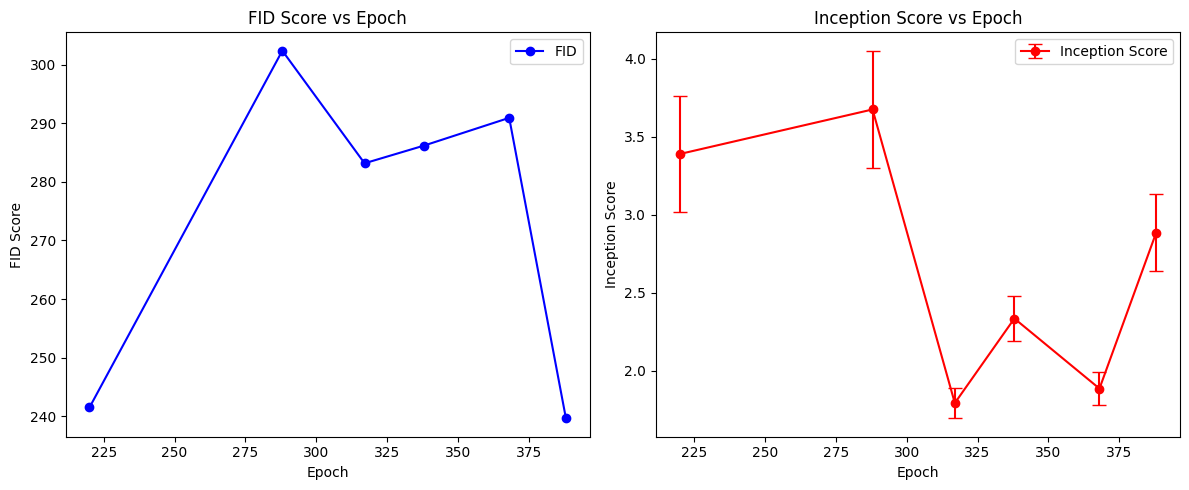


--- Insights ---
Best FID: 239.64 at epoch 388
Best Inception Score: 3.674 at epoch 288
Observe the trends: FID should decrease and IS should increase as the model improves. Sudden jumps may indicate mode collapse or instability.


In [19]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# List of generator checkpoint files and their epochs
gen_ckpts = [
    (220, "/kaggle/input/projec/gennormal_220.pth"),
    (288, "/kaggle/input/projec/gennormal_288.pth"),
    (317, "/kaggle/input/projec/gennormal_317.pth"),
    (338, "/kaggle/input/projec/gennormal_338.pth"),
    (368, "/kaggle/input/projec/gennormal_368.pth"),
    (388, "/kaggle/input/projec/gennormal_388.pth"),
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test loader and n_words
batch_size = 32
test_loader, n_words = create_loader(256, batch_size, "/kaggle/input/projec/cv_seattention/cv_seattention/data", "test")

# Load CLIPTextEncoder
text_encoder = CLIPTextEncoder.load("/kaggle/input/projec/clip_text_encoder.pth", n_words).to(device)
text_encoder.eval()
for p in text_encoder.parameters():
    p.requires_grad = False

# InceptionV3 class as in your code
class InceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True).to(self.device)
        self.linear = self.model.fc
        self.model.fc, self.model.dropout = [nn.Sequential()] * 2

    @torch.no_grad()
    def get_last_layer(self, x):
        x = F.interpolate(x, size=300, mode='bilinear', align_corners=False, recompute_scale_factor=False)
        return self.model(x)

classifier = InceptionV3().to(device).eval()

def calculate_fid(repr1, repr2):
    mu_r, mu_g = np.mean(repr1, axis=0), np.mean(repr2, axis=0)
    sigma_r, sigma_g = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)
    diff = mu_r - mu_g
    diff_square_norm = diff.dot(diff)
    product = sigma_r.dot(sigma_g)
    sqrt_product, _ = linalg.sqrtm(product, disp=False)
    if not np.isfinite(sqrt_product).all():
        eye_matrix = np.eye(sigma_r.shape[0]) * 1e-8
        sqrt_product = linalg.sqrtm((sigma_r + eye_matrix).dot(sigma_g + eye_matrix))
    if np.iscomplexobj(sqrt_product):
        sqrt_product = sqrt_product.real
    fid = diff_square_norm + np.trace(sigma_r + sigma_g - 2 * sqrt_product)
    return fid

def inception_score(reprs, batch_size):
    def get_pred(x):
        x = classifier.linear(torch.tensor(x, dtype=torch.float))
        return F.softmax(x).data.cpu().numpy()
    preds = np.zeros((reprs.shape[0], 1000))
    splits = 0
    for i in range(0, len(preds), batch_size):
        aaai = reprs[i:i + batch_size]
        aai = torch.tensor(aaai).to(device)
        z = get_pred(aai)
        preds[i:i + batch_size] = z
        splits += 1
    split_scores = []
    for k in range(splits):
        part = preds[k * batch_size: (k+1) * batch_size, :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores), np.std(split_scores)

def build_representations(generator, text_encoder):
    real_reprs = np.zeros((len(test_loader) * batch_size, 2048))
    fake_reprs = np.zeros((len(test_loader) * batch_size, 2048))
    idx = 0
    for batch in tqdm(test_loader, desc="Build representations"):
        images, captions, captions_len, file_names = prepare_data(batch, device)
        with torch.no_grad():
            sent_emb, word = text_encoder(captions, captions_len)
            sent_emb = sent_emb.detach()
            word = word.detach()
            fake_images = generator(torch.randn(images.size(0), 100).to(device), sent_emb, word)
            clf_out_real = classifier.get_last_layer(images)
            clf_out_fake = classifier.get_last_layer(fake_images)
        real_reprs[idx: idx + images.size(0)] = clf_out_real.cpu().numpy()
        fake_reprs[idx: idx + images.size(0)] = clf_out_fake.cpu().numpy()
        idx += images.size(0)
    return real_reprs, fake_reprs

# Store results
epochs = []
fid_scores = []
is_means = []
is_stds = []

for epoch, ckpt_path in gen_ckpts:
    print(f"\n===== Epoch {epoch} =====")
    # Load generator
    generator = Generator(n_channels=32, latent_dim=100).to(device)
    checkpoint = torch.load(ckpt_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()
    # Build representations
    real_values, fake_values = build_representations(generator, text_encoder)
    # FID
    fid_value = calculate_fid(real_values, fake_values)
    # Inception Score
    is_mean, is_std = inception_score(fake_values, batch_size)
    # Print results
    print(f"FID: {fid_value:.2f}")
    print(f"Inception Score: mean={is_mean:.3f}, std={is_std:.3f}")
    # Store for plotting
    epochs.append(epoch)
    fid_scores.append(fid_value)
    is_means.append(is_mean)
    is_stds.append(is_std)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, fid_scores, 'bo-', label='FID')
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Score vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(epochs, is_means, yerr=is_stds, fmt='ro-', capsize=5, label='Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.title('Inception Score vs Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Insights
print("\n--- Insights ---")
print(f"Best FID: {min(fid_scores):.2f} at epoch {epochs[np.argmin(fid_scores)]}")
print(f"Best Inception Score: {max(is_means):.3f} at epoch {epochs[np.argmax(is_means)]}")
print("Observe the trends: FID should decrease and IS should increase as the model improves. Sudden jumps may indicate mode collapse or instability.")
